In [1]:
import numpy as np
import pandas as pd
from random import random, seed, randrange
import matplotlib.pyplot as plt
%matplotlib inline

## Defining Artificial Neural Network Class

In [2]:
# https://towardsdatascience.com/coding-a-2-layer-neural-network-from-scratch-in-python-4dd022d19fd2
# https://towardsdatascience.com/the-keys-of-deep-learning-in-100-lines-of-code-907398c76504

class ANN:
    # intializing the network input and parameters
    def __init__(self, dims):
        self.dims = dims  
        self.Yh = np.zeros((dims[2],1)) 
        self.param = {}
        self.ch = {}
        self.loss = []
        self.lr = 0.01
        
    def Init_weights(self):    
        # initialize the parameters of our network with random values
        np.random.seed(42)
        self.param['W1'] = np.random.randn(self.dims[1], self.dims[0]) / np.sqrt(self.dims[0]) 
        self.param['b1'] = np.zeros((self.dims[1], 1))        
        self.param['W2'] = np.random.randn(self.dims[2], self.dims[1]) / np.sqrt(self.dims[1]) 
        self.param['b2'] = np.zeros((self.dims[2], 1))      
        #print('W1:', self.param)
        return
    
    def Sigmoid(self, Z):
        return 1/(1+np.exp(-Z)) 
    
    def Relu(self, Z):
        return np.maximum(0,Z)
    
    def forward(self,Xa,yb):    
        Z1 = self.param['W1'].dot(Xa) + self.param['b1'] 
        #A1 = self.Relu(Z1)
        A1 = self.Sigmoid(Z1)
        self.ch['Z1'], self.ch['A1'] = Z1, A1
        
        Z2 = self.param['W2'].dot(A1) + self.param['b2']  
        A2 = self.Sigmoid(Z2)
        #A2 = self.Relu(Z2)
        self.ch['Z2'], self.ch['A2'] = Z2, A2
        self.yh = A2
        #print("Yh:", self.yh)
        squared_errors = (self.yh - yb) ** 2
        #print('sq error:', squared_errors)
        loss_sum = np.sum(squared_errors)
        #print("loss sum:", loss_sum)
        return self.yh, loss_sum
    
    def dRelu(self, x):
        x[x<=0] = 0
        x[x>0] = 1
        return x
    
    def dSigmoid(self, Z):
        s = 1/(1+np.exp(-Z))
        dZ = s * (1-s)
        return dZ
    
    def backward(self,Xa,yb):
        dLoss_Yh = -(yb - self.yh)
        dLoss_Z2 = dLoss_Yh * self.dSigmoid(self.ch['Z2'])    
        #dLoss_Z2 = dLoss_Yh * self.dRelu(self.ch['Z2'])   
        dLoss_A1 = np.dot(self.param["W2"].T,dLoss_Z2)
        dLoss_W2 = 1. * np.dot(dLoss_Z2,self.ch['A1'].T)
        dLoss_b2 = 1. * np.dot(dLoss_Z2, np.ones([dLoss_Z2.shape[1],1])) 
                            
        #dLoss_Z1 = dLoss_A1 * self.dRelu(self.ch['Z1'])
        dLoss_Z1 = dLoss_A1 * self.dSigmoid(self.ch['Z1']) 
        dLoss_A0 = np.dot(self.param["W1"].T,dLoss_Z1)
        dLoss_W1 = 1. * np.dot(dLoss_Z1,Xa.T)
        dLoss_b1 = 1. * np.dot(dLoss_Z1, np.ones([dLoss_Z1.shape[1],1])) 
        
        self.param["W1"] = self.param["W1"] - self.lr * dLoss_W1
        self.param["b1"] = self.param["b1"] - self.lr * dLoss_b1
        self.param["W2"] = self.param["W2"] - self.lr * dLoss_W2
        self.param["b2"] = self.param["b2"] - self.lr * dLoss_b2
        
    def sgd(self,Xa, yb, iter = 20):
        for i in range(0, iter):
            yh, loss_sum = self.forward(Xa,yb)
            self.backward(Xa,yb)        
        return 
    
    def pred(self,x, y):  
        comp = np.zeros((1,x.shape[1]))
        pred, loss_sum = self.forward(x,y)  
        comp = np.around(pred,0)
        #print("Acc: " + str(np.sum((comp == y)/x.shape[1])))
        
        return comp, loss_sum
        

## Function for transforming Y to take care of multi-class output

In [3]:
def transform_Xy(x_df,y_df):
    X = x_df.values.transpose()
    yu = y_df.unique()
    ydict = {}
    for i in yu:
        key = 'y'+str(yu[i])
        ydict[key] = [1 if val==yu[i] else 0 for val in y_df]
    yc_df = pd.DataFrame(ydict)
    y = yc_df.values.transpose()
    return X, y, yc_df, yu

def back_transform_y(y_pred, yu):
    ycap = []
    for i in y_pred.T:
        index = np.where(i == 1)
        if index[0].size == 0:
            index = 0
        else:
            index = index[0][0]
        #print(j, ':', index)
        ycap.append(yu[index])
    return ycap

## Reading the data and initialising the ANN

In [4]:
df = pd.read_csv('Iris.csv')
x_df = df[['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']]
y_df = df['class']

X, y, yc_df, yu = transform_Xy(x_df,y_df)

input_layer = X.shape[0]
hidden_layer1 = 15
output_layer = y.shape[0]
dims = [input_layer, hidden_layer1, output_layer]

nn = ANN(dims)
nn.Init_weights()
nn.lr = 0.05

## Training the ML Model and finding accuracy

In [5]:
loss = []
for epoch in range(151):
    for i in range(1,X.shape[1]):
        X1 = x_df.iloc[i:i+1].values.transpose()
        y1 = np.array(yc_df.iloc[i:i+1].values.transpose())
        nn.sgd(X1, y1, iter=10)
        
    if epoch % 10 == 0:
        ytemp, ls = nn.pred(X, y)
        print ("Cost after Epoch %i: %.2f" %(epoch, ls))
        loss.append(ls)
    
y_pred, loss_sum = nn.pred(X, y)
ycap = back_transform_y(y_pred,yu)
cc = np.sum(y==ycap)
wc = np.sum(y!=y_pred)
print("Percentage of correct classification: {:.2f}%".format(cc*100.0/(cc+wc)))
print("Percentage of wrong classification: {:.2f}%".format(wc*100.0/(cc+wc)))

Cost after Epoch 0: 171.14
Cost after Epoch 10: 89.66
Cost after Epoch 20: 73.51
Cost after Epoch 30: 55.51
Cost after Epoch 40: 42.30
Cost after Epoch 50: 34.13
Cost after Epoch 60: 28.92
Cost after Epoch 70: 25.32
Cost after Epoch 80: 22.66
Cost after Epoch 90: 20.61
Cost after Epoch 100: 18.97
Cost after Epoch 110: 17.62
Cost after Epoch 120: 16.50
Cost after Epoch 130: 15.54
Cost after Epoch 140: 14.73
Cost after Epoch 150: 14.05
Percentage of correct classification: 88.68%
Percentage of wrong classification: 11.32%


## Plotting loss function

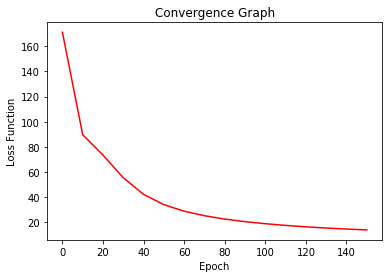

In [7]:
e = np.arange(0,epoch+1,10)
fig, ax = plt.subplots()
ax.set(xlabel = 'Epoch', 
       ylabel = 'Loss Function',
       title = 'Convergence Graph')
ax.plot(e,loss,'-r')
plt.show()

In [10]:
ycap

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2]